Name: &emsp;&nbsp;&nbsp;&nbsp;Lukas Grosse Westermann  
E-Mail: &emsp;&nbsp;&nbsp;&nbsp;lukas.grossewestermann@stud.hslu.ch  
Progam: &emsp;M.Sc. Applied Information and Data Science @ Hochschule Luzern  
GitHub: &emsp;&nbsp;&nbsp;https://github.com/Lukasgw/HSG_FashionMNIST


# Introduction 

At the end of the course "Deep Learning" of the Global School in Empirical Research Methods of the University of St. Gallen, students were given the task to create two Convolutional Neural Networks. The goal of the work is to generate a solution for the FashionMNIST challange of Zalando. The task is to successfully classify images of clothes.

# Importation of the required libraries to Jupyter Notebook

At the beginning all necessary libraries have to be imported and the connection to the Google Cloud (Gdrive) will be established.

In [ ]:
#create connection to google drive and mount GDrive inside the Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#standard python libraries for data processing
import os, urllib, io
from datetime import datetime
import numpy as np

# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

In [ ]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/GSERM/Deep_Learning/Assignment_Lukas_GrosseWestermann'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/GSERM/Deep_Learning/Assignment_Lukas_GrosseWestermann/data_fashionMNIST'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/GSERM/Deep_Learning/Assignment_Lukas_GrosseWestermann/models_fashionMNIST'
if not os.path.exists(models_directory): os.makedirs(models_directory)

In [ ]:
# set deterministic seed to get reproducible results
seed_value = 42 #answer to everything :-)
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

In [ ]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Convolutional Neural Networks

## Baseline CNN

### Preparation

#### Step 1. define "train" path 

In [ ]:
train_path = data_directory + '/train_fmnist'

#### Step 2. define transformations / downloading the "train" dataset / quick check

In [ ]:
# defining the pytorch transformation into the tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# downloading and transforming the training images
fashion_mnist_train_data = torchvision.datasets.FashionMNIST(root=train_path, train=True, transform=transf, download=True)

# qick check --> should be 60000
len(fashion_mnist_train_data)



60000

#### Step 3. setup/define labels

In [ ]:
#defining the fashion classes
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

#### Step 4. define "eval" path

In [ ]:
eval_path = data_directory + '/eval_fmnist'

#### Step 5. define transformation and download the "eval" dataset 

In [ ]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_eval_data = torchvision.datasets.FashionMNIST(root=eval_path, train=False, transform=transf, download=True)

# qick check --> should be 10000
len(fashion_mnist_eval_data)

10000

### Baseline Convolutional Neural Network (CNN) model training and evaluation

#### Step 1. - CNN structure / network architecture 

In [ ]:
class FashionMNIST_assignment_baseline(nn.Module):
    
    # class constructor
    def __init__(self):
        
        # call super class constructor
        super(FashionMNIST_assignment_baseline, self).__init__()
        
        # convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1, padding=0)
        
        # max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=4, stride=1, padding=0)
        
        # max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # fully-connected (fc) layer 1 - in 12*4*4, out 120 [since Layer has 1*12*4*4 structure]
        self.linear1 = nn.Linear(12*4*4, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # fc layer 2 - in 120, out 60
        self.linear2 = nn.Linear(120, 60, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # fc layer 3 - in 60, out 10
        self.linear3 = nn.Linear(60, 10) # the linearity W*x+b
        
        # softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # network forward pass
    def forward(self, images):


        # high-level feature learning via convolutional layers
        
        # conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))
        
        # conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))


        # feature flattening

        # reshape image pixels
        x = x.view(-1,12*4*4)
                
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x



In [ ]:
#initialize the model
model = FashionMNIST_assignment_baseline()
model = model.to(device)

In [ ]:
# structure of the Network
print('[LOG] FashionMNIST_assignment_baseline architecture:\n\n{}\n'.format(model))

[LOG] FashionMNIST_assignment_baseline architecture:

FashionMNIST_assignment_baseline(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=192, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=60, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=60, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



In [ ]:
# init the number of model parameters
num_params = 0

# iteration over the distinct parameters
for param in model.parameters():

    # collection number of parameters
    num_params += param.numel()
    
# printing the number of model paramters
print('[LOG] Number of to be trained FashionMNIST_assignment_baseline model parameters: {}.'.format(num_params))

[LOG] Number of to be trained FashionMNIST_assignment_baseline model parameters: 32296.


#### Step 2. loss, training hyperparameters and dataloader 

In [ ]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

# training hyperparameters
num_epochs = 25 # number of training epochs
mini_batch_size = 192 # size of the mini-batches
learning_rate = 0.001 # learning rate
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate) #optimazation strategy

#dataloader
fashion_mnist_train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train_data, batch_size=mini_batch_size, shuffle=True)


#### Step 3. run model training 

In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# setting the model into training mode
model.train()

# training the FashionMNIST_assignment_baseline model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iteration over all-mini batches
    for i, (images, labels) in enumerate(fashion_mnist_train_dataloader):
        
        # pushing mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # running forward pass through the network
        output = model(images)
        
        # resetting graph gradients
        model.zero_grad()
        
        # determining classification loss
        loss = nll_loss(output, labels)
        
        # running backward pass
        loss.backward()
        
        # updating network paramaters
        optimizer.step()
        
        # collecting mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determining mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # printing epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # setting filename of actual model
    model_name = 'FashionMNIST_assignment_baseline_model_epoch_{}.pth'.format(str(epoch))

    # saving current model to GDrive models directory
    torch.save(model.state_dict(), os.path.join(models_directory, model_name))
    
    # determining mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)



[LOG 20220702-20:18:10] epoch: 0 train-loss: 2.3026309561805602
[LOG 20220702-20:18:26] epoch: 1 train-loss: 2.2998102770064968
[LOG 20220702-20:18:40] epoch: 2 train-loss: 2.29772435590482
[LOG 20220702-20:18:55] epoch: 3 train-loss: 2.2957841611137026
[LOG 20220702-20:19:09] epoch: 4 train-loss: 2.2937367465168523
[LOG 20220702-20:19:24] epoch: 5 train-loss: 2.291413152560639
[LOG 20220702-20:19:38] epoch: 6 train-loss: 2.288694163861747
[LOG 20220702-20:19:52] epoch: 7 train-loss: 2.285702481437415
[LOG 20220702-20:20:07] epoch: 8 train-loss: 2.2822241531774257
[LOG 20220702-20:20:21] epoch: 9 train-loss: 2.2779954751840417
[LOG 20220702-20:20:36] epoch: 10 train-loss: 2.2727579004086627
[LOG 20220702-20:20:50] epoch: 11 train-loss: 2.2659652263592607
[LOG 20220702-20:21:05] epoch: 12 train-loss: 2.256876715455954
[LOG 20220702-20:21:19] epoch: 13 train-loss: 2.244515806722184
[LOG 20220702-20:21:33] epoch: 14 train-loss: 2.226677407852758
[LOG 20220702-20:21:48] epoch: 15 train-los

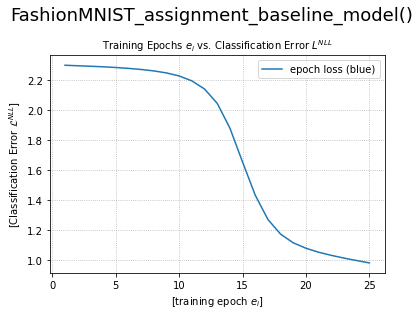

In [ ]:
# The training loss compared to the epochs will be shown in this plot

# preparation of the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# adding grid
ax.grid(linestyle='dotted')

# plotting the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# adding axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# setting plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# adding plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10)
plt.suptitle('FashionMNIST_assignment_baseline_model()', y=1.05, fontsize=18);

#### Step 4. run model evaluation 

##### Importing Model and Preparation

In [ ]:
#### Step 4. run model evaluation 

# The best model will be downloaded directly into this notebook from my github repository

# restoring pre-trained model snapshot
best_model_name = 'https://github.com/Lukasgw/HSG_FashionMNIST/raw/main/FashionMNIST_assignment_baseline_model_epoch_24.pth'

# reading stored model
model_bytes = urllib.request.urlopen(best_model_name)

# loading model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# init pre-trained model class
best_model = FashionMNIST_assignment_baseline()

# loading pre-trained models
best_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# seting model in evaluation mode
best_model.eval()

FashionMNIST_assignment_baseline(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=192, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=60, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=60, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [ ]:
# Evaluation DataLoader
fashion_mnist_eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval_data, batch_size=10000, shuffle=False)

In [ ]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterating over all-mini batches
for i, (images, labels) in enumerate(fashion_mnist_eval_dataloader):

    # running forward pass through the network
    output = best_model(images)

    # determining classification loss
    loss = nll_loss(output, labels)

    # collecting mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determining mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# printing epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20220702-15:58:02] eval-loss: 0.9878020286560059


##### Accuray on test data

In [ ]:
# making predictions
predictions = torch.argmax(best_model(iter(fashion_mnist_eval_dataloader).next()[0]), dim=1)

In [ ]:
# Accuracy of the model
round(metrics.accuracy_score(fashion_mnist_eval_data.targets, predictions.detach()),2)

0.63

##### Confusion Matrix

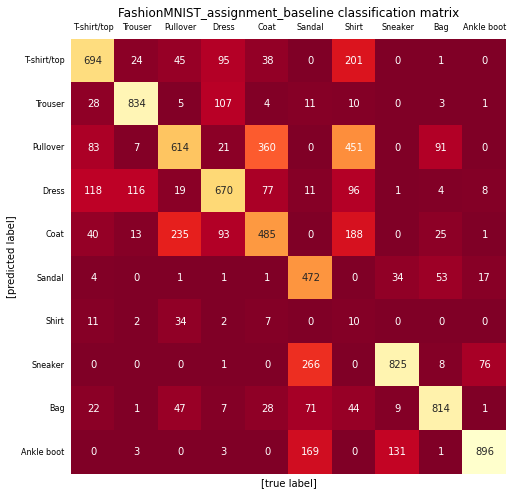

In [ ]:
# determining classification matrix of the predicted and target classes
mat = confusion_matrix(fashion_mnist_eval_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# ploting corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# setting plot title
plt.title('FashionMNIST_assignment_baseline classification matrix')

# setting axis labels
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

The first CNN was successfully implemented, it consists of 32296 parameters and can correctly match the images with a probability of 63.14%. Compared to a random assignment (10%) this is already a significant improvement but the second CNN will change a few things in the following to make it even better.

## Improved CNN

### Preparation

This step can be skipped because the same data is used as for the first CNN.

### Improved Convolutional Neural Network (CNN) model training and evaluation

#### Step 1. - CNN structure / network architecture 

In [ ]:
# implementing the MNISTNet network architecture
class FashionMNIST_assignment_improved(nn.Module):
    
    # defining the class constructor
    def __init__(self):
        
        # calling super class constructor
        super(FashionMNIST_assignment_improved, self).__init__()
        
        # convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=1, padding=0)
        
        # max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0)
        
        # max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully-connected (fc) layer 1 - in 20*4*4, out 120 [since Layer has 1*20*4*4 structure]
        self.linear1 = nn.Linear(20*4*4, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 120, out 60
        self.linear2 = nn.Linear(120, 60, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 60, out 10
        self.linear3 = nn.Linear(60, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):


        # high-level feature learning via convolutional layers
        
        # conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))
        
        # conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))


        # feature flattening

        # reshape image pixels
        x = x.view(-1,20*4*4)
                
        # fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x

In [ ]:
# initialization of the model
model = FashionMNIST_assignment_improved()
model = model.to(device)

In [ ]:
# structure of the Network
print('[LOG] FashionMNIST_assignment_improved architecture:\n\n{}\n'.format(model))

[LOG] FashionMNIST_assignment_improved architecture:

FashionMNIST_assignment_improved(
  (conv1): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=320, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=60, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=60, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



In [ ]:
# init the number of model parameters
num_params = 0

# iteration over the distinct parameters
for param in model.parameters():

    # collection number of parameters
    num_params += param.numel()
    
# printing the number of model paramters
print('[LOG] Number of to be trained FashionMNIST_assignment_improved model parameters: {}.'.format(num_params))

[LOG] Number of to be trained FashionMNIST_assignment_improved model parameters: 51580.


#### Step 2. loss, training hyperparameters and dataloader 

In [ ]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

# training hyperparameters
num_epochs = 120 
mini_batch_size = 192 
learning_rate = 0.0009
betas=(0.9, 0.999)
foreach=None
maximize=False
capturable=False
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate) #optimazation strategy

#dataloader
fashion_mnist_train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train_data, batch_size=mini_batch_size, shuffle=True)


#### Step 3. run model training 

In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# setting the model into training mode
model.train()

# training the FashionMNIST_assignment_baseline model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iteration over all-mini batches
    for i, (images, labels) in enumerate(fashion_mnist_train_dataloader):
        
        # pushing mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # running forward pass through the network
        output = model(images)
        
        # resetting graph gradients
        model.zero_grad()
        
        # determining classification loss
        loss = nll_loss(output, labels)
        
        # running backward pass
        loss.backward()
        
        # updating network paramaters
        optimizer.step()
        
        # collecting mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determining mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # printing epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # setting filename of actual model
    model_name = 'FashionMNIST_assignment_improved_model_epoch_{}.pth'.format(str(epoch))

    # saving current model to GDrive models directory
    torch.save(model.state_dict(), os.path.join(models_directory, model_name))
    
    # determining mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)



[LOG 20220702-14:56:53] epoch: 0 train-loss: 0.32152445100176447
[LOG 20220702-14:57:14] epoch: 1 train-loss: 0.3090701148913691
[LOG 20220702-14:57:35] epoch: 2 train-loss: 0.2982700957943456
[LOG 20220702-14:57:56] epoch: 3 train-loss: 0.28422879425291053
[LOG 20220702-14:58:16] epoch: 4 train-loss: 0.27252576950068674
[LOG 20220702-14:58:37] epoch: 5 train-loss: 0.2665117601997936
[LOG 20220702-14:58:58] epoch: 6 train-loss: 0.257842040171448
[LOG 20220702-14:59:23] epoch: 7 train-loss: 0.2501857521149297
[LOG 20220702-14:59:48] epoch: 8 train-loss: 0.24409872988542428
[LOG 20220702-15:00:14] epoch: 9 train-loss: 0.23675755663706471
[LOG 20220702-15:00:35] epoch: 10 train-loss: 0.23330626029747362
[LOG 20220702-15:00:55] epoch: 11 train-loss: 0.2259312424654016
[LOG 20220702-15:01:16] epoch: 12 train-loss: 0.21964214861202544
[LOG 20220702-15:01:38] epoch: 13 train-loss: 0.21302497382171617
[LOG 20220702-15:02:00] epoch: 14 train-loss: 0.20957690113173505
[LOG 20220702-15:02:21] epo

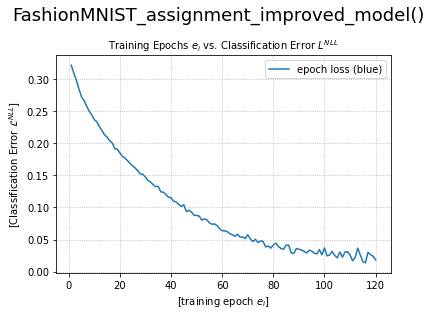

In [ ]:
# The training loss compared to the epochs will be shown in this plot

# preparation of the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# adding grid
ax.grid(linestyle='dotted')

# plotting the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# adding axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# setting plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# adding plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);
plt.suptitle('FashionMNIST_assignment_improved_model()', y=1.05, fontsize=18);

#### Step 4. run model evaluation 

##### Importing Model and Preparation

In [ ]:
#### Step 4. run model evaluation 

# The best model will be downloaded directly into this notebook from my github repository

# restoring pre-trained model snapshot
best_model_name = 'https://github.com/Lukasgw/HSG_FashionMNIST/raw/main/FashionMNIST_assignment_improved_model_epoch_115.pth'

# reading stored model
model_bytes = urllib.request.urlopen(best_model_name)

# loading model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# init pre-trained model class
best_model = FashionMNIST_assignment_improved()

# loading pre-trained models
best_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# seting model in evaluation mode
best_model.eval()

FashionMNIST_assignment_improved(
  (conv1): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=320, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=60, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=60, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [ ]:
fashion_mnist_eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval_data, batch_size=10000, shuffle=False)

In [ ]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterating over all-mini batches
for i, (images, labels) in enumerate(fashion_mnist_eval_dataloader):

    # running forward pass through the network
    output = best_model(images)

    # determining classification loss
    loss = nll_loss(output, labels)

    # collecting mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determining mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# printing epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20220702-15:42:23] eval-loss: 0.8146467208862305


##### Accuray on test data

In [ ]:
# making predictions
predictions = torch.argmax(best_model(iter(fashion_mnist_eval_dataloader).next()[0]), dim=1)

In [ ]:
# Accuracy of the model
round(metrics.accuracy_score(fashion_mnist_eval_data.targets, predictions.detach()),2)

0.9

##### Confusion Matrix

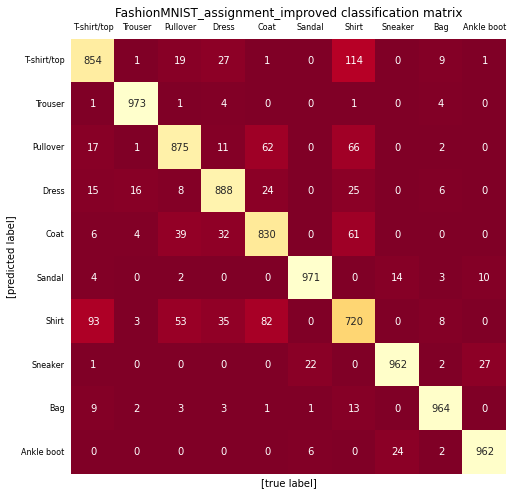

In [ ]:
# determining classification matrix of the predicted and target classes
mat = confusion_matrix(fashion_mnist_eval_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# ploting corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# setting plot title
plt.title('FashionMNIST_assignment_improved classification matrix')

# setting axis labels
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

## Conclusion / Final words

The second CNN could be improved significantly. It consists of a total of 51580 parameters and classifies the images correctly with a probability of 90%. This is a significant improvement over the first model. More tests could be done but the training of the current model took about 50 minutes, for more performance additional capacity would have to be purchased from Google. 
Nevertheless, much could be learned with this task.